## Training (Neural Network edition)
After loading and preprocessing the data, we can now train the model.

### First things first
Importing libraries. Make sure you have them installed (check the instructions in the `README.md`)
And then, splitting 

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# Load the processed data
df = pd.read_csv('data/' + 'train_processed.csv')

# Split features and labels
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


### Defining model architecture
I'm going with a 2-layer MLP (64 and 32 neurons, respectively).

In [2]:
class MLP(nn.Module):
    def __init__(self, n_inputs, hidden_sizes=[128,32], dropout=0.1):
        super().__init__()
        layers = []
        in_features = n_inputs
        for h in hidden_sizes:
            layers += [
                nn.Linear(in_features, h),  # linear transform
                nn.ReLU(),                  # non-linearity
                nn.BatchNorm1d(h),         # normalize activations
                #nn.Dropout(dropout)        # regularize
            ]
            in_features = h
        layers += [nn.Linear(in_features, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


In [3]:
n_features = len(X_train.columns)
print(n_features)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Initialize new model
model = MLP(n_features)

17


In [4]:
print(y_train.unique())
print(y_train.dtype)
print(y_train.value_counts(normalize=True))

print(X_train.head())
print(X_train.describe())



[1 0]
int64
Transported
1    0.501869
0    0.498131
Name: proportion, dtype: float64
      HomePlanet  CryoSleep  Destination   Age  VIP  Cabin_ID_1  Cabin_ID_2  \
7074         1.0          0          0.0  18.0    0          13        1561   
6710         0.0          1          0.0  32.0    0          10         259   
2569         0.0          1          2.0  36.0    0           9          85   
3850         0.0          0          0.0  23.0    0           9         130   
7450         0.0          0          0.0  35.0    0           9         260   

      Cabin_ID_3  GroupRank  GroupSize  RoomService_Cat  FoodCourt_Cat  \
7074           3          1          1                0              2   
6710           4          1          2                0              0   
2569           3          1          1                0              0   
3850           3          1          1                0              0   
7450           3          2          2                1              2

Epoch 1/12, Loss: 0.6450
Epoch 2/12, Loss: 0.5463
Epoch 3/12, Loss: 0.5234
Epoch 4/12, Loss: 0.5138
Epoch 5/12, Loss: 0.5108
Epoch 6/12, Loss: 0.5010
Epoch 7/12, Loss: 0.4987
Epoch 8/12, Loss: 0.4951
Epoch 9/12, Loss: 0.4932
Epoch 10/12, Loss: 0.4952
Epoch 11/12, Loss: 0.4881
Epoch 12/12, Loss: 0.4847


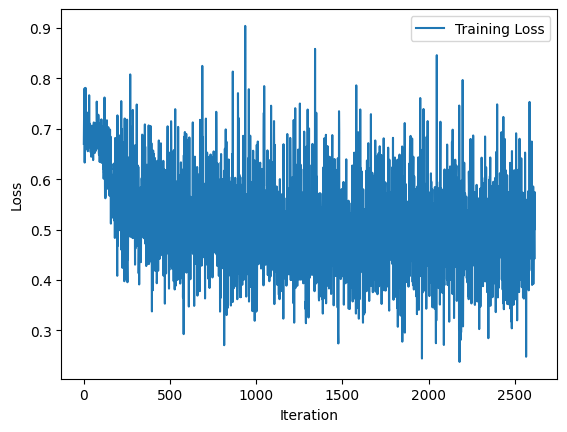

Final loss: 0.4433884024620056


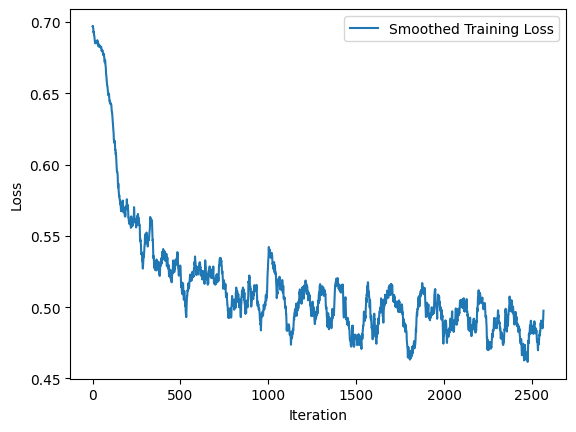

In [5]:
from torch.utils.data import TensorDataset, DataLoader

# Prepare tensors
X_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)


# Hyperparameters
batch_size = 32
num_epochs = 12
learning_rate = 0.0005

# Dataset and DataLoader
ds = TensorDataset(X_tensor, y_tensor)
dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

# Model, loss, optimizer
model = MLP(n_inputs=n_features)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
losses = []


# Training loop
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for X_batch, y_batch in dl:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * X_batch.size(0)
        losses.append(loss.item())

    epoch_loss /= len(dl.dataset)
    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Plot losses
plt.figure()
plt.plot(losses, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

def moving_average(x, window_size=50):
    return np.convolve(x, np.ones(window_size)/window_size, mode='valid')

smoothed_losses = moving_average(losses, window_size=50)

print(f"Final loss: {losses[-1]}")

plt.figure()
plt.plot(smoothed_losses, label="Smoothed Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()


.49 v01
.44